# CLASSIFICATION OF LAB SAMPLES

This notebook analyzes the accuracy of the SVM classifier on the training data and on lab samples.
The training data are:
* all genes (not just regulators);
* averaged;
* do not include T1 (since only one observtion)

# TO DO
1. **Check calculation of pooled, whether average log**
1. Structure codes for the analyses conducted. This structure should be reflected in ``DATA_DCT``.
   1. Selection of genes: myco, myco +, all genes
   1. How counts are processed
      1. Reference - T0/biostat, T0/data source, pooled/data source
1. Evaluation of classifiers
   1. Performance on biostat data
   1. Performance on other samples
      1. Time consistency
      1. Replication consistency
      1. Consistency with expectation
1. Analyses for Eliza:
   1. Accuracy with all 11 and the accuracy as you add in more genes (same as what you just sent but with all 11).
   1. Could you test with just the 10 mycobactin genes (Rv2377c-Rv2386c)?
   1. Could you test with just bacterioferritin (Rv3841)? Just Rv2384?
   1. Is there one gene that gives good accuracy
1. compare accuracy with ranom selection of genes
1. Classifier coefficient profile.
   1. Eliza genes - 1-10
   1. Auto selected genes: 5, 10, 20

# Preliminaries

## Imports

In [16]:
import init
from common import constants as cn
from common_python.util import dataframe
from tools.mk_classification_data import ClassificationData

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline

In [2]:
data = ClassificationData()
data.get(globals())

## Constants

## Helper Functions

In [5]:
def plotSampleData(data_dct, genes= None, is_plot=True):
    """
    Plots trinary values of data for the specified genes.
    
    Parameters
    ----------
    data_dct: dict
        key: reference type
        value: sample dictionary
            key: sample name
            value: features
    genes: list-str
    """
    ref_types = list(data_dct.keys())
    sample_names = list(data_dct[ref_types[0]].keys())
    for sample_name in sample_names:
        for ref_type in ref_types:
            df_X = data_dct[ref_type][sample_name]
            if genes is None:
                genes = list(df_X.columns)
            TRINARY.plotExpressionLevels(genes, df_X=df_X, title=ref_type + ", " + sample_name, is_plot=is_plot)
            
# Tests
plotSampleData(SAMPLE_DCT, genes=MYCOBACTIN_BACTERIOFERRIN_GENES, is_plot=False)
print("OK!")

OK!


In [6]:
def reportSamplePredictions(data_dct):
    for name, df_X in data_dct.items():
        print("\n%s" % name)
        df_pred = CLASSIFIER.predict(df_X)
        new_columns = [STAGE_NAMES[c] for c in df_pred.columns]
        df_pred.columns = new_columns
        print(df_pred)

## Gene Expression

**Observations**
1. Prefer control values that avoid having a constant value of the trinary value over the samples (since such a situation is unhelpful for distinguishing classes).
1. On training data (Bioreactor)
   1. Many genes have the same within class values
   1. Few genes have the same between class values

**TO DO**: Plot data in pairs, 1 column, 2 rows; this allows comparisons of the expressions for T0 vs. pooled.

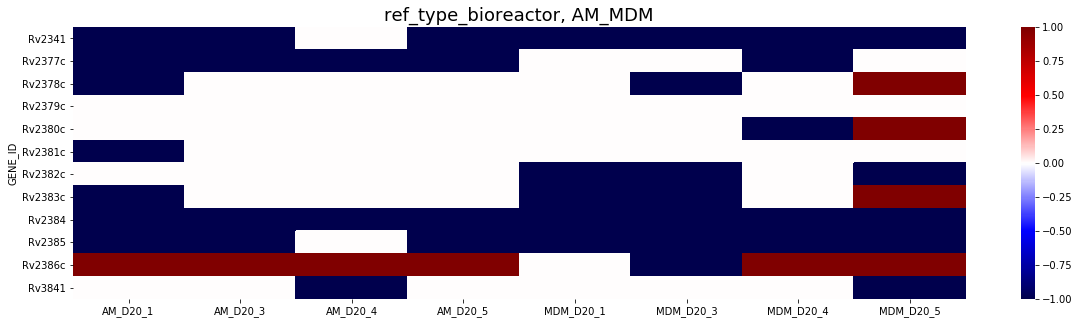

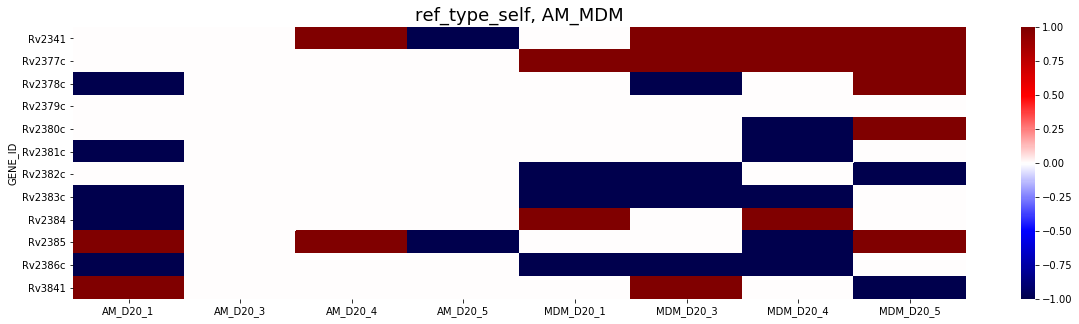

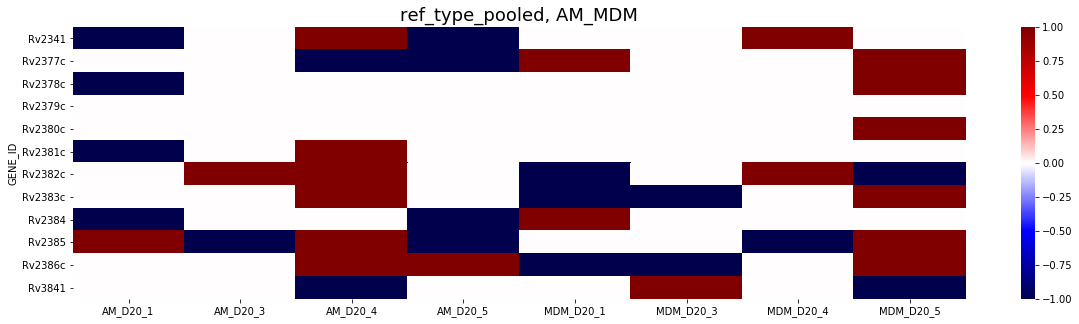

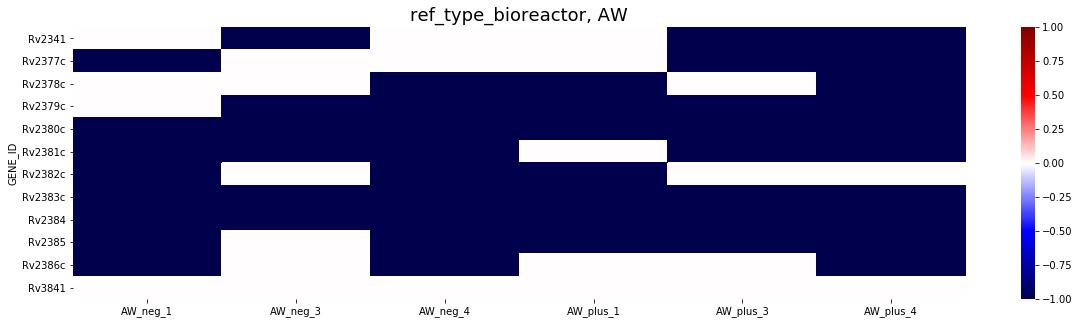

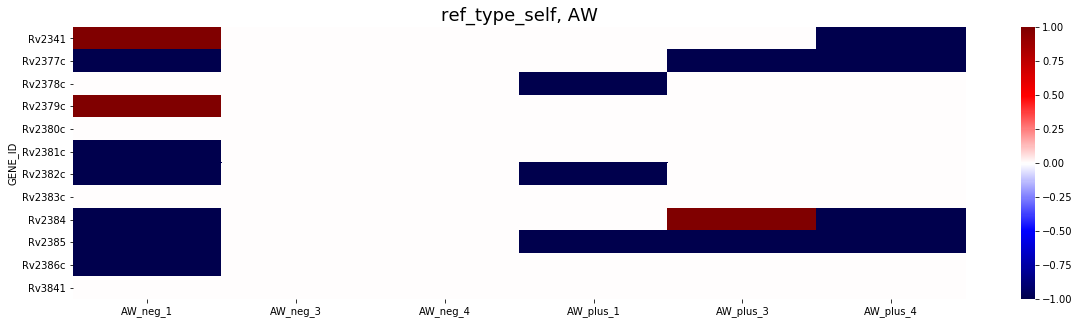

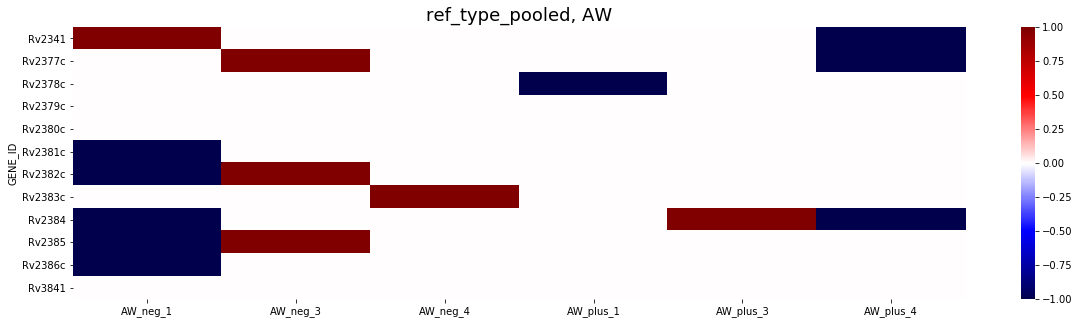

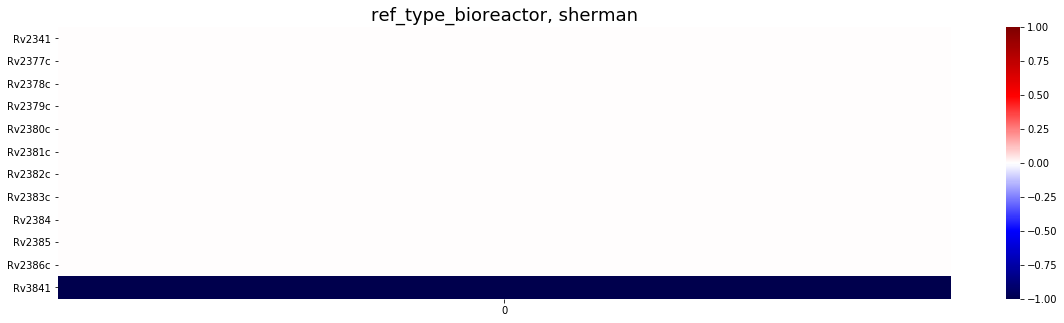

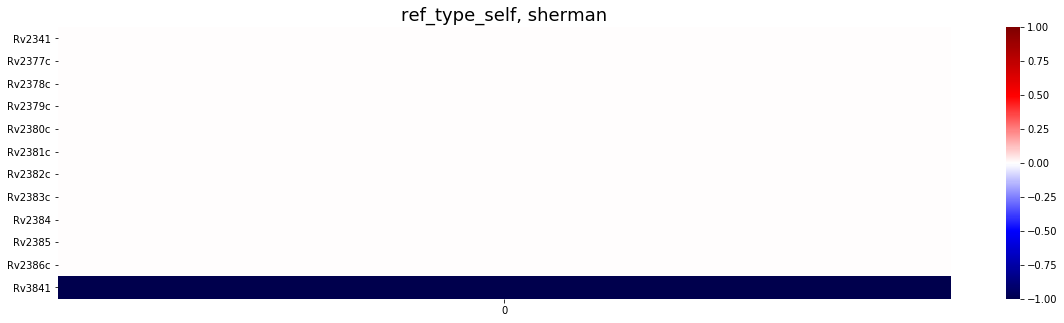

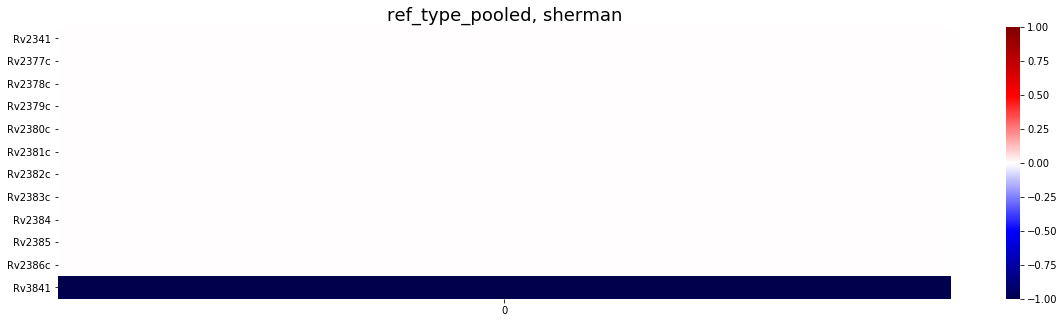

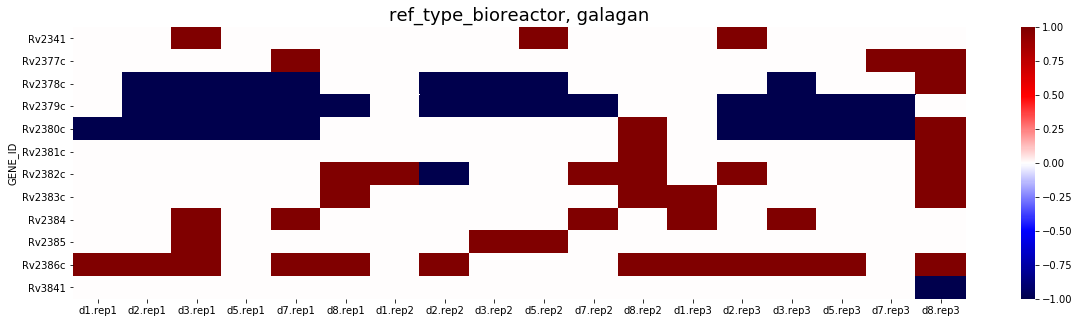

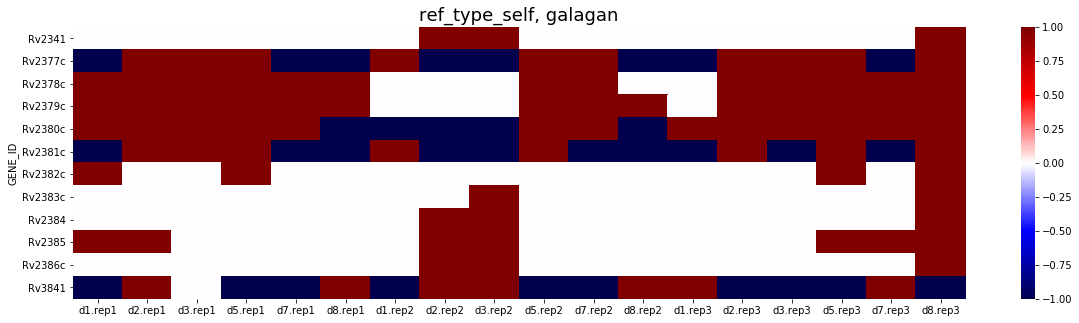

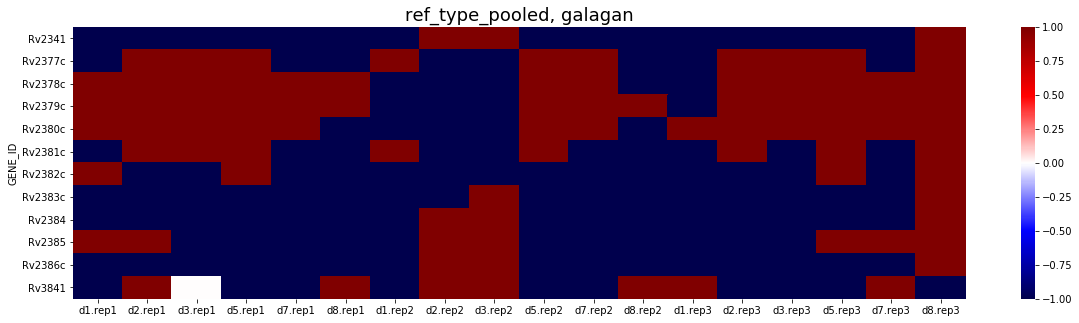

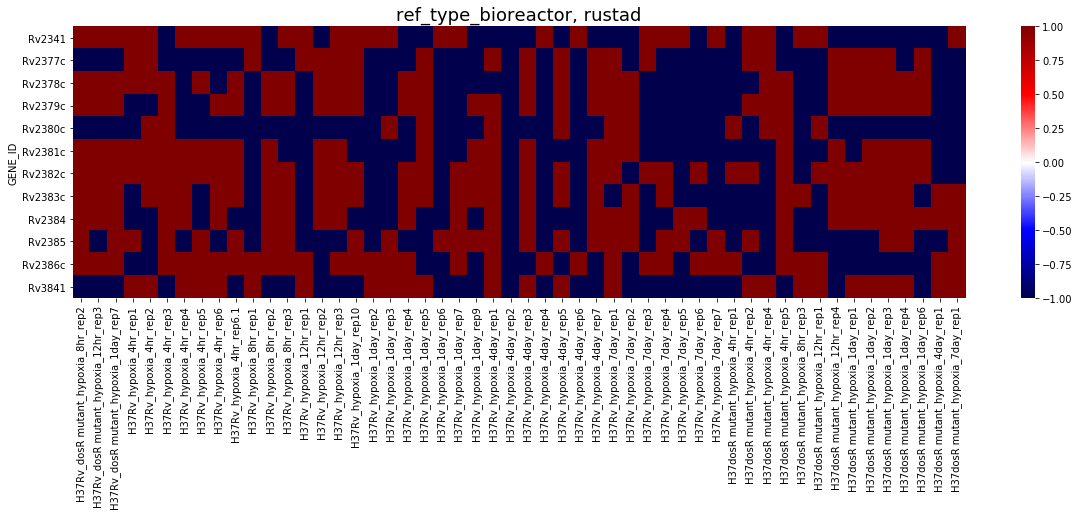

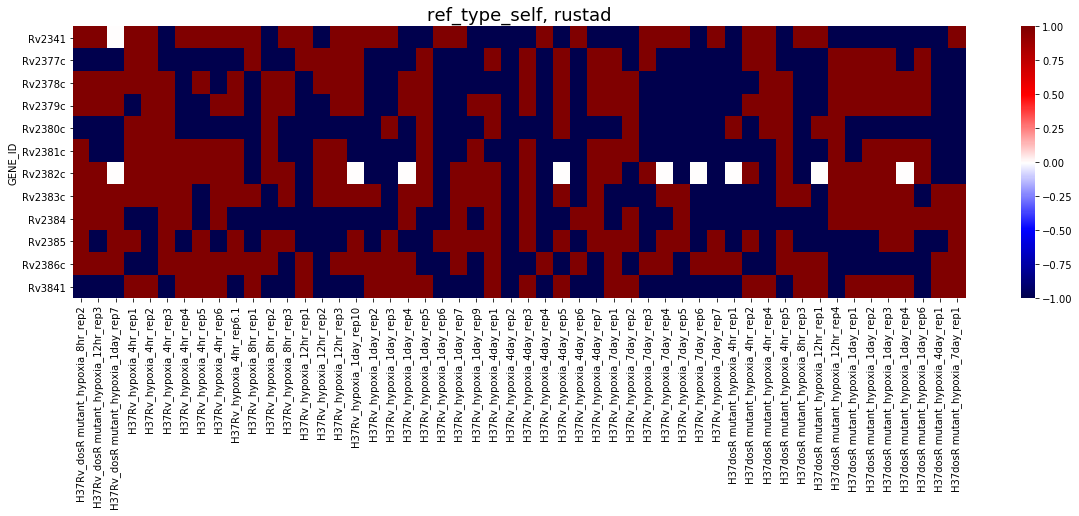

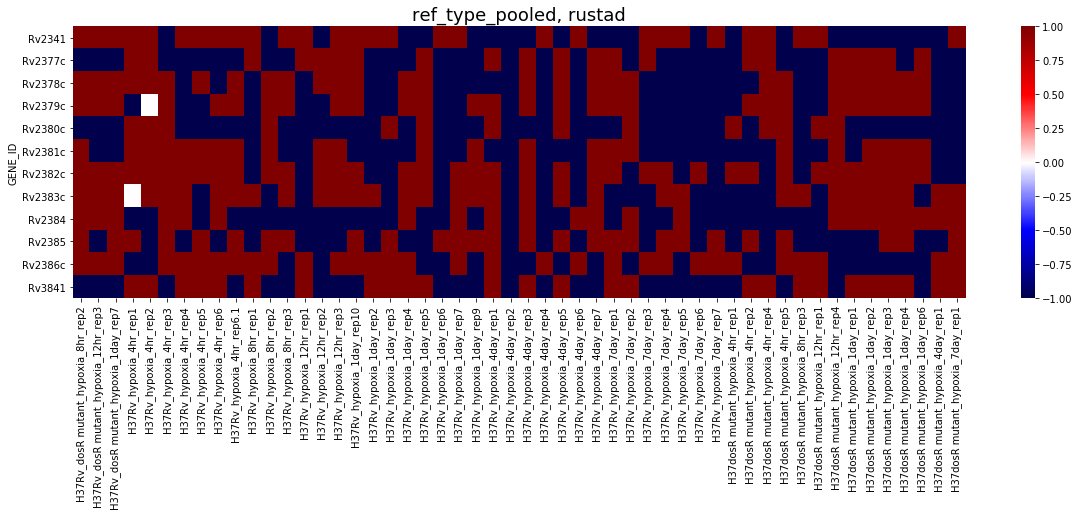

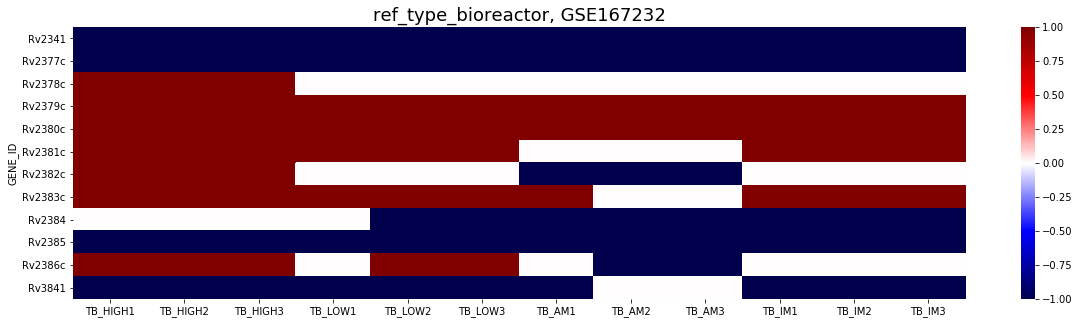

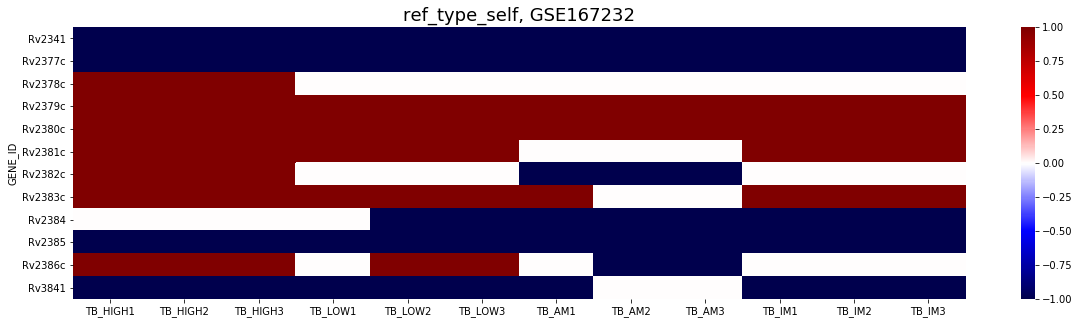

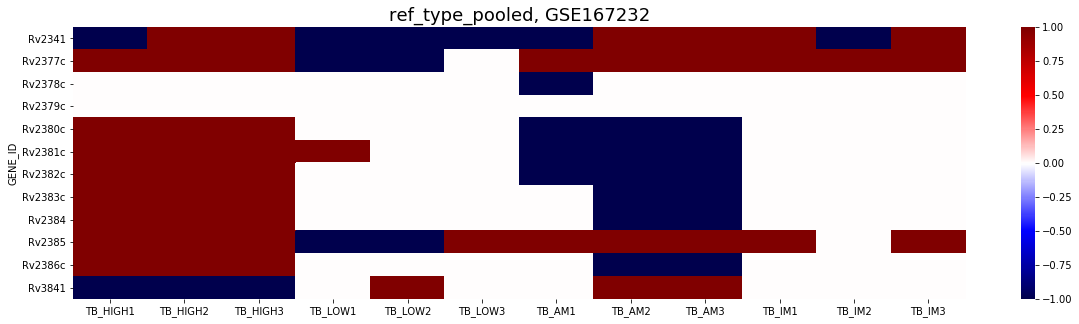

In [10]:
# With Bioreactor reference data
plotSampleData(SAMPLE_DCT, genes=MYCOBACTIN_BACTERIOFERRIN_GENES)

# Classification of Samples

In [ ]:
CLASSIFIER.features

In [ ]:
CLASSIFIER.predict(SAMPLE_DATA_DCT["AM_MDM"])

In [ ]:
reportSamplePredictions(SAMPLE_DCT[REF_TYPE_BIOREACTOR])

In [ ]:
reportSamplePredictions(SAMPLE_DCT[REF_TYPE_POOLED])

# Detailed Analyses

## GSE167232

In [ ]:
TRINARY.plotExpressionLevels(CLASSIFIER.features, df_X=SAMPLE_DATA_DCT["GSE167232"], title="GSE167232")

In [ ]:
TRINARY.plotExpressionLevels(CLASSIFIER.features, df_X=SAMPLE_DCT[REF_TYPE_POOLED]["GSE167232"], title="GSE167232")

In [ ]:
#CLASSIFIER.plotFeatureContributions(df_X.loc["TB_AM1",:], class_names=STAGE_NAMES)
df_predict = CLASSIFIER.predict(SAMPLE_DATA_DCT["GSE167232"])
indexArr = np.reshape(list(df_predict.index), (4,3))
num_row = 4
num_col =3
_, axes = plt.subplots(num_row, num_col, figsize=(20, 12))
for irow in range(4):
    for icol in range(3):
        if icol == 0:
            is_ylabel = True
        else:
            is_ylabel = False
        if icol == num_col - 1:
            is_legend = True
        else:
            is_legend = False
        if irow == num_row - 1:
            is_xlabel = True
        else:
            is_xlabel = False
        instance = indexArr[irow, icol]
        ser_X = SAMPLE_DATA_DCT["GSE167232"].loc[instance, :]
        CLASSIFIER.plotFeatureContributions(ser_X, class_names=STAGE_NAMES, title=instance, ax=axes[irow,icol], is_plot=False,
                                           is_xlabel=is_xlabel, is_ylabel=is_ylabel, is_legend=is_legend)
plt.show()

## Rustad

In [ ]:
for ref_type in [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]:
    _, ax = plt.subplots(1)
    df_X = SAMPLE_DCT[ref_type]["rustad"]
    # Select hypoxia samples
    sel =  ["H37Rv_hypoxia" in i and (not "10" in i) for i in df_X.index]
    df_X = df_X[sel]
    # Select just replication 1-3
    sel =  [any([r in i for r in ["rep1", "rep2", "rep3"]])  for i in df_X.index]
    df_X = df_X[sel]
    #
    replFunc = lambda i: i[-4:]
    timeFunc = lambda i: i[-9:-6].replace("_", "")
    #time_strs = ["4hr", "12hr", "1day", "4day", "7day"]
    title = "rustad: " + ref_type
    CLASSIFIER.plotReplicationsOverTime(df_X, replFunc, timeFunc, title=title, ax=ax)

## AM, MDM

In [ ]:
SAMPLE_DATA_DCT["AM_MDM"]

## Galagan

In [ ]:
for ref_type in [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]:
    df_X = SAMPLE_DCT[ref_type]["galagan"]
    prediction_df = CLASSIFIER.predict(df_X)
    replFunc = lambda i: i[-4:]
    timeFunc = lambda i: i[0:2]
    title = "galagan: " + ref_type
    _, ax = plt.subplots(1)
    CLASSIFIER.plotReplicationsOverTime(df_X, replFunc, timeFunc, title=title, ax=ax)

# Summary Comments

1. Choice of control
   1. Criteria for choice
1. Evaluating the quality of classification for test samples
   1. Consistency between replications
   1. Consistency in stage progression of replication
1. Detailed summaries for data sets
1. Selection of genes based on classification accuracy selects some, but not all of the mycobactin genes. 
   1. Which are not selected?
   1. What additional genes are selected?
   1. What are the signs and magnitudes of the mycobactin genes in the "all" case?
1. Using pooled data results in very different gene selections